# Fusulinids species identification
**A ML implementation using Convolutional Neural Network (CNN) to identify extinct species by**
#### **Meng Chen**, **Yukun Shi**                                         
[Centre of Research and Education of Biological Evolution and Environment](https://es.nju.edu.cn/crebee/)  
[School of Earth Sciences and Engineering](https://www.nju.edu.cn/EN/7f/80/c7136a163712/page.psp)  
[Nanjing University](https://www.nju.edu.cn/EN/)

## **Introduction**

Fusulinids are one of the most informative fossils present in the stratigraphic horizon. Particularly, petroleum industry relies on them to for signaing the deposit layer of oil and natural gas. Certain species only occurred in those horizon. Identifying species becomes endless effort by oil industry. Recently, the machine learning becomes more practical, from a simple chatbot from the customer service of AT&T, to the prodcut recommendation system of Amazon, and to the sophistical AlphaGo of Google AI. Machine learning becomes more and more close to our regular life and even challenge the current life choice (e.g., self-driving car) and maybe replace our jobs (e.g., truck drivers) in near future.

Today, with computational power increases drastically, the machine learning implementation is not the personal matter of the supercomputer anymore, workstation or even a personal computer can successfully training the model with proper specs (e.g., Nivdia Quadro graphic card with CUDA enabled). To pioneering implementation of machine learning techniques in paleobiology, my collaborators and I have investigated how to identify fusulinids with convolutional neural network (CNN). The projects will have two phases based on the quality of the data, fined-tuned images vs raw images. The ultimate goal of this project will be the implementation of CNN for identifying the fusulinids species without numerous manual tuning on the original images, saving workload for initial assessments of the new genus or species. Broadly, this project will build a framework for identifying organism elements, teeth for example, to help differentiate the species identity or functions based on physical morphology.

## **Data**
The data was provided by [Dr. Yikun Shi](https://es.nju.edu.cn/crebee/fjs/list.htm), Deputy Director of the [Centre for Research and Education on Biological Evolution and Environment](https://es.nju.edu.cn/crebee/), Nanjing University. The image data has been heavily preprocessed by adjusting the contrast and brightness and cropping out non-informative parts of the original images. Each image has also been resized to the same size as well as for the same resolution. See some examples in the sample folder.

## **Data augumentation**
The original dataset has 119 images, which were far from enough for deep learning neural network. To alliviate the issue, I used `ImageDataGenerator` in `keras.preprocessing.image` to perform the data augmentation. After the data augmentation, we have 6,928 images in total for the training the CNN model.

![](fig_1.jpg)

**Fig. 1** Some examples of the fusulinid images in the dataset.

## **Model**
The convolutional neural network (CNN) is implemented with `Keras` API (`TensorFlow` backend). Because the images of fusulinids are less complicated than those of biomedical counterparts, our CNN model is a much simpler architecture than that of U-net. In total, the CNN has 31,723,782 trainable parameters in total. I applied `Adam` as optimizer and `sparse_categorical_crossentropy` for loss function. See the codes below for details.

```python
def build_cnn(input_size=(255, 255, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(128, 3, activation='relu')(inputs)
    conv2 = Conv2D(128, 3, activation='relu')(conv1)
    conv3 = Conv2D(64, 3, activation='relu')(conv2)
    pool1 = MaxPooling2D(pool_size=(4, 4))(conv3)
    flat1 = Flatten()(pool1)
    relu1 = Activation('relu')(flat1)
    drop1 = Dropout(rate=0.5)(relu1)
    dense1 = Dense(128, activation='relu')(drop1)
    drop2 = Dropout(rate=0.5)(dense1)
    dense2 = Dense(64, activation='relu')(drop2)
    dense3 = Dense(6, activation='softmax')(dense2)
    model = Model(inputs=inputs, outputs=dense3)
    model.compile(
        optimizer='Adam',
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model
```
## **Results**
The accuracy of the CNN model for 50-epoch training session is 0.9852 and 0.9863 for training and validation datasets, respectively. These are encouraging results for implementing the CNN for identifying the fusulinids at the first phase.

![](fig_2.png)
**Fig. 2** The results of the training of CNN models on fusulinids.

## **Future step**
After the first phase of identifying the fusulinids successfully using well-preprocessed images, we are moving the projects forward to using raw data. Currently, we are still in collecting a much larger dataset of raw images of the fusulinids.

## **Details**
### **Import necessory libraries**

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import IPython.display as display
from PIL import Image
import numpy as np
import pathlib
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Flatten, Conv2D, Reshape, MaxPooling2D, Activation, Dropout
from keras.preprocessing.image import load_img, img_to_array
from keras import Sequential, Model
from matplotlib import pyplot as plt

Using TensorFlow backend.


### **Checking the versions of imported libraries**

In [22]:
print('Numpy version: ', np.__version__)
print('Keras version: ', keras.__version__)
print('TensorFlow version: ', tf.__version__)

Numpy version:  1.18.1
Keras version:  2.2.4
TensorFlow version:  1.15.0


### **Create image_generator using** `ImageDataGenerator` **and import all images**

In [36]:
# create a image generator
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# checking the number of images of augumented dataset
path = "augumented"
data_dir = pathlib.Path(path)
image_count = len(list(data_dir.glob('*/*.jpg')))
print('The augmented data has {} images.'.format(image_count))

# genus_names
GENUS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != '.DS_Store'])
print('The fusulinids genus includes', GENUS_NAMES)

The augmented data has 6928 images.
The fusulinids genus includes ['Robustoschwgerina' 'Sphaeroschwgerina' 'Zellia' 'Triticites'
 'Pseudoschwagerina' 'Verbeekina']


### **A randomly sampled triticties specimen**

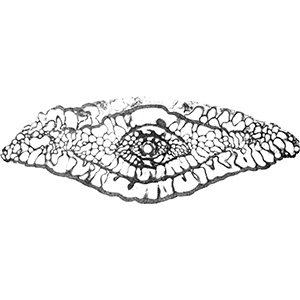

In [24]:
Triticites = list(data_dir.glob('Triticites/*'))
n_specimens = len(Triticites)
rand_num = np.random.randint(n_specimens)
display.display(Image.open(str(Triticites[rand_num])))

### **Define batch size and image size**

In [50]:
BATCH_SIZE = 32
IMG_HEIGHT = 255
IMG_WIDTH = 255
STEP_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
# training data batch generator
train_generator = image_generator.flow_from_directory(
    directory=str(data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='sparse',
    classes = list(GENUS_NAMES)
)

Found 6928 images belonging to 6 classes.


### **Check lalels of the sampled species**

In [26]:
list(train_generator.class_indices)

['Pseudoschwagerina',
 'Robustoschwgerina',
 'Sphaeroschwgerina',
 'Triticites',
 'Verbeekina',
 'Zellia']

### **Show batched samples**

In [27]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        plt.title(GENUS_NAMES[np.int(label_batch[n])])
        plt.axis('off')

The shape of the data is (32, 255, 255, 3)


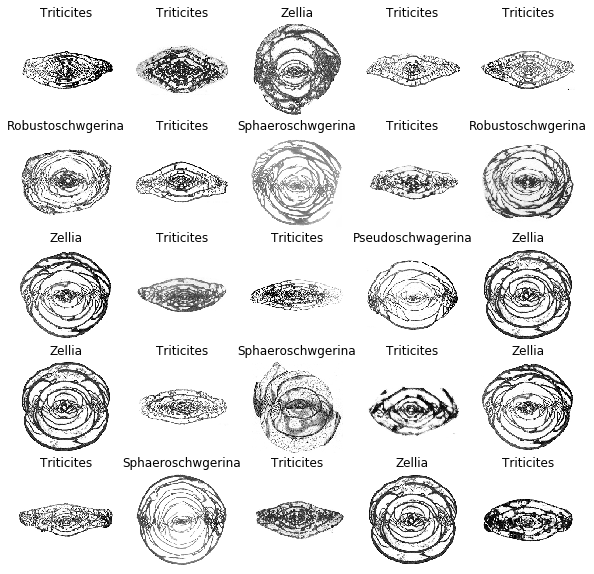

In [28]:
image_batch, label_batch = next(train_generator)
print('The shape of the data is', image_batch.shape)
show_batch(image_batch, label_batch)

### **Build validation batches**

In [53]:
# data validation batch generator
data_dir = pathlib.Path('augumented')
image_count = len(list(data_dir.glob('*/*.jpg')))
valid_generator = image_generator.flow_from_directory(
    directory=str(data_dir),
    batch_size=1,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='sparse',
    classes = list(GENUS_NAMES)
)

Found 6928 images belonging to 6 classes.


### **Build the CNN**

In [60]:
def build_cnn(input_size=(255, 255, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(128, 3, activation='relu')(inputs)
    conv2 = Conv2D(128, 3, activation='relu')(conv1)
    conv3 = Conv2D(64, 3, activation='relu')(conv2)
    pool1 = MaxPooling2D(pool_size=(4, 4))(conv3)
    flat1 = Flatten()(pool1)
    relu1 = Activation('relu')(flat1)
    drop1 = Dropout(rate=0.5)(relu1)
    dense1 = Dense(128, activation='relu')(drop1)
    drop2 = Dropout(rate=0.5)(dense1)
    dense2 = Dense(64, activation='relu')(drop2)
    dense3 = Dense(6, activation='softmax')(dense2)
    model = Model(inputs=inputs, outputs=dense3)
    model.compile(
        optimizer='Adam',
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

In [61]:
model = build_cnn()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 255, 255, 3)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 253, 253, 128)     3584      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 251, 251, 128)     147584    
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 249, 249, 64)      73792     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 246016)            0         
_________________________________________________________________
activation_9 (Activation)    (None, 246016)            0         
__________

### **Training the CNN**

In [63]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=step_size_train,
    validation_data=valid_generator,
    validation_steps=step_size_valid,
    epochs=50,
    verbose=1
)

Epoch 1/50
216/216 [==============================] - 90s 416ms/step - loss: 0.2248 - acc: 0.9285 - val_loss: 0.0395 - val_acc: 0.9769
Epoch 2/50
216/216 [==============================] - 90s 418ms/step - loss: 0.0686 - acc: 0.9779 - val_loss: 0.0304 - val_acc: 0.9815
Epoch 3/50
216/216 [==============================] - 90s 418ms/step - loss: 0.0499 - acc: 0.9799 - val_loss: 0.0312 - val_acc: 0.9861
Epoch 4/50
216/216 [==============================] - 90s 419ms/step - loss: 0.0467 - acc: 0.9795 - val_loss: 0.0273 - val_acc: 0.9861
Epoch 5/50
216/216 [==============================] - 90s 419ms/step - loss: 0.0352 - acc: 0.9850 - val_loss: 0.0270 - val_acc: 0.9861
Epoch 6/50
216/216 [==============================] - 91s 419ms/step - loss: 0.0331 - acc: 0.9816 - val_loss: 0.0274 - val_acc: 0.9861
Epoch 7/50
216/216 [==============================] - 90s 419ms/step - loss: 0.0329 - acc: 0.9816 - val_loss: 0.0267 - val_acc: 0.9861
Epoch 8/50
216/216 [==============================] - 9

### **Visualize the training results**

In [64]:
def plot_history(history):
    '''plot the history of the cnn model'''
    history_dict = history.history
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    figs, axes = plt.subplots(1, 2, figsize=(16, 6))
    # plot the results of the training set
    axes[0].plot(epochs, loss, 'r-', label='Training loss')
    axes[0].plot(epochs, acc, 'b-', label='Training acc')
    axes[0].set_title('Training results')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    # plot the results of the validation 
    axes[1].plot(epochs, val_loss, 'r-', label='Validation loss')
    axes[1].plot(epochs, val_acc, 'b-', label='Validation acc')
    axes[1].set_title('Validation results')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.show()

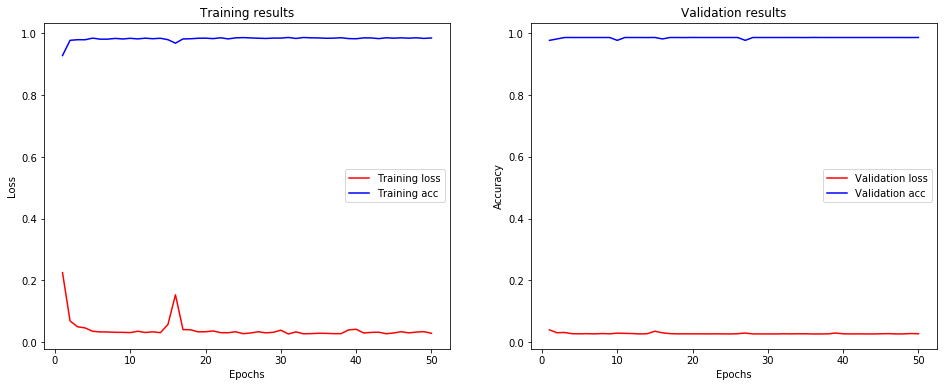

In [65]:
plot_history(history)

### **Save the model**

In [66]:
model.save('./model/id_fusulinids.h5')

## **Identify fusulinids species**

### **Loading model**

In [3]:
model = tf.keras.models.load_model('./model/id_fusulinids.h5')

### **A random sample of species**

In [22]:
data_dir = pathlib.Path('sample')
genus = list(data_dir.glob('Verbeekina/*'))
n_specimens = len(genus)
rand_num = np.random.randint(n_specimens)
rand_num

7

### **Processing the image of specimen**

In [25]:
img = load_img(str(genus[rand_num]), target_size=(255, 255))
img_arr = img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr = img_arr / 255

### **Predict**

In [26]:
results = model.predict(img_arr)
results[0]

array([6.4387683e-11, 6.8824862e-11, 1.1055642e-10, 3.2164701e-13,
       1.0000000e+00, 1.3642192e-13], dtype=float32)

In [34]:
values = np.argsort(results)[0][-3:][::-1]
species = {'Pseudoschwagerina': 0,
           'Robustoschwagerina': 1,
           'Sphaeroschwagerina': 2,
           'Triticites': 3,
           'Verbeekina': 4,
           'Zellia': 5}

In [35]:
labels = {v:k for k, v in zip(species.keys(), species.values())}

In [38]:
# top three predictions with highest probability to the lowest one
final_results = [labels[v] for v in values]

In [39]:
final_results

['Verbeekina', 'Sphaeroschwagerina', 'Robustoschwagerina']

In [41]:
prds = sorted(results[0])[-3:][::-1]

In [45]:
print({v:p for v,p in zip(final_results, prds)})

{'Verbeekina': 1.0, 'Sphaeroschwagerina': 1.1055642e-10, 'Robustoschwagerina': 6.882486e-11}


In [43]:
import streamlit as st